In [101]:
#Loading the libraries.
import numpy as np
import pandas as pd
import re
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 
from sklearn.cluster import KMeans
from sklearn import datasets
from nltk import ngrams
import time
import random
import warnings
warnings.filterwarnings("ignore")
from sklearn.preprocessing import KBinsDiscretizer

In [2]:
#Using this to discretize and create the combined_feature but for all scenarios. s
def data_discretizer(data):        
    #Fixing the labels to appropriate values. Background->-1, Normal->0, Malicious->,1.
    data=data.copy()
    Labels = [] 
    for i in data.Label.values:
        if re.search("Background",i)!=None:
            Labels.append(-1)
        elif re.search("Normal",i)!=None:
            Labels.append(0)
        elif re.search("Botnet",i)!=None:
            Labels.append(1)
    data["Label"]=Labels
    data.Label.unique()
    #Creating new dataframe by removing background netflow data.
    data_WB = data.loc[data["Label"]!=-1]
    #Due to large number of missing values, removing dTos and Dport as it will only cloud results. Removing sTos as it's useless.
    data_WB_cleaned = data_WB.drop(columns=["dTos","Dport","sTos"])
    # For the label encoding, replacing nans with default values for State and Sport and converting them to categorical. 
    data_WB_cleaned.loc[data_WB['State'].isna(),'State'] = "UNK"
    data_WB_cleaned.loc[data_WB['Sport'].isna(),'Sport'] = '0000'
    data_WB_cleaned.loc[:,"Sport"]=data_WB_cleaned["Sport"].astype('category')
    data_WB_cleaned.loc[:,"State"]=data_WB_cleaned["State"].astype('category')
    #Converting categorical variables in numerical ones using label encoder to be used for correlation. 
    from sklearn import preprocessing
    le = preprocessing.LabelEncoder()
    categorical_columns=['Proto','Dir','SrcAddr','DstAddr',"State","Sport"]
    for i in categorical_columns:
        data_WB_cleaned.loc[:,i] = le.fit_transform(data_WB_cleaned[i])
    Binner = KBinsDiscretizer(n_bins=3, encode='ordinal', strategy='kmeans')
    data_discrete = Binner.fit_transform(data_WB_cleaned.loc[:,["Dur","TotBytes"]])
    data_discrete = pd.DataFrame(data_discrete,columns=["New_Dur","New_TotBytes"])
    data_discrete["Labels"]= data_WB_cleaned.Label.values
    data_discrete["SrcAddr"]= data_WB_cleaned.SrcAddr.values
    combined_levels=[]
    for i,j in zip(data_discrete["New_Dur"].values,data_discrete["New_TotBytes"].values):
        if (i==0) & (j==0):
            combined_levels.append("Combined_Level_1")
        elif (i==0) & (j==1):
            combined_levels.append("Combined_Level_2")
        elif (i==0) & (j==2):
            combined_levels.append("Combined_Level_3")
        elif (i==1) & (j==0):
            combined_levels.append("Combined_Level_4")
        elif (i==1) & (j==1):
            combined_levels.append("Combined_Level_5")
        elif (i==1) & (j==2):
            combined_levels.append("Combined_Level_6")
        elif (i==2) & (j==0):
            combined_levels.append("Combined_Level_7")
        elif (i==2) & (j==1):
            combined_levels.append("Combined_Level_8")
        elif (i==2) & (j==2):
            combined_levels.append("Combined_Level_9")
    data_discrete.loc[:,"Combined_Levels"]=combined_levels
    return data_discrete

In [3]:
#Loading in all scenarios.
data0 = pd.read_csv("capture20110817.binetflow")
data1 = pd.read_csv("capture20110818.binetflow")
data2 = pd.read_csv("capture20110819.binetflow")
data3 = pd.read_csv("capture20110818-2.binetflow")
dataMerged =pd.concat([data0,data1,data2,data3])

In [4]:
data_discrete=data_discretizer(dataMerged)
data_discrete_train = data_discrete.sample(frac=0.5, replace=False, random_state=1)
data_discrete_eval = data_discrete.sample(frac=0.5, replace=False, random_state=1)

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


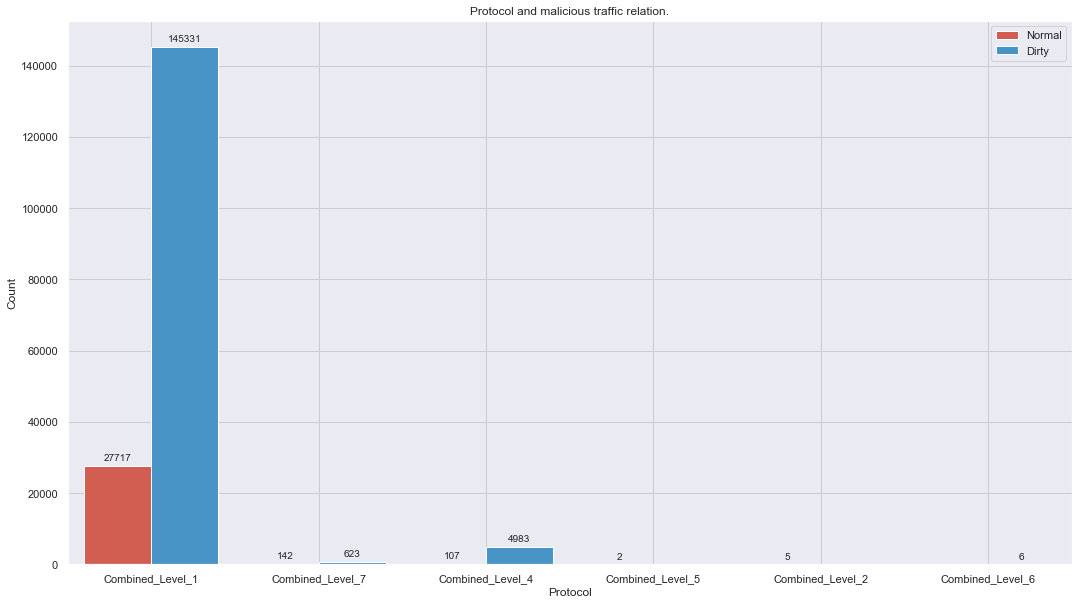

In [5]:
sns.set(rc={'figure.figsize':(18,10)})
    
flatui = ["#e74c3c","#3498db", "#2ecc71"]
ax = sns.countplot(x="Combined_Levels", hue="Labels", data=data_discrete_train, palette=flatui)
ax.set_title('Protocol and malicious traffic relation.')
ax.grid(color='#cccccc')
ax.set_ylabel('Count')
ax.set_xlabel('Protocol')
ax.legend(["Normal", "Dirty"])
max_height = 0

for p in ax.patches:
    if p.get_height() > max_height:
        max_height = p.get_height()
    
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2,
            height + 0.01*max_height,'{:1d}'.format(height.astype(int)),
            ha="center",size=10)

This figure gives us a count for each of the levels of the combined_features for malicious and normal netflows. We see combined_level_1 majorily represents malicious netflows. 

In [6]:
def Ngram_profile_generator(data_discrete):
    
    data= data_discrete.copy()
    #All source Ips.
    Srcs=set(data["SrcAddr"].values)
    # The malicious source IPs or hosts. 
    M_src=set(data.loc[data["Labels"]==1]["SrcAddr"].values)

    #Getting the combined_features for each source IP and creating n-grams. 
    datasubsets=[]
    for i in Srcs:
        datasubsets.append(data.loc[(data["SrcAddr"]==i)])

    Combined_pairF=[]
    for i in datasubsets:
        Combined_pairF.append(i["Combined_Levels"].values)    

    Ngram_combined_pairF=[]

    for i in Combined_pairF:
        threegrams = ngrams(i, 3)
        Ngram_combined_pairF.append(threegrams)     

    # Big dicky stores the different n-grams and their counts for each ip-pair.     
    BigDicky=[]
    for i in Ngram_combined_pairF:
        dicky={}
        for j in i:
            s = "-"
            s = s.join(j)
            dicky[s] = dicky.get(s, 0) + 1

        BigDicky.append(dicky) 

    #Removing the empty ip_pairs.
    index=[]
    for i in enumerate(BigDicky):
        if len(list(i[1].keys()))!=0:
            index.append(i[0]) 
    BigDicky_pure = [i[1] for i in enumerate(list(BigDicky)) if i[0] in index]        
    BigDicky=BigDicky_pure

    ind=list(set(Srcs)-(set(Srcs)-set(index))) 

    #Total number of the different n-gram types. 
    allkeys=[]
    for i in BigDicky:
        for j in list(i.keys()):
            allkeys.append(j)
    len(set(allkeys))  


    # creating the table of 
    # Here the rows are the ip source profiles and the columns are the different n-gram types.
    # 1 indicates that the ngram was present and 0 otherwise. 

    df=pd.DataFrame(np.zeros((len(BigDicky),len(set(allkeys)))),columns=list(set(allkeys)))

    for k in enumerate(BigDicky):
        for i in df.columns:
            if i in list(k[1].keys()):
                df.loc[k[0],i]=k[1][i]

    df=df.set_index(pd.Series(list(ind))) 
    M_df=df.loc[M_src,:]
    N_df= df.loc[list(set(ind)-set(M_src))]

    return df,M_df,N_df

In [7]:
#Extracting the Ngram tables from the full dataset as well as just malicious and Normal. 
df,M_df,N_df = Ngram_profile_generator(data_discrete_train)

In [8]:
df

,Combined_Level_7-Combined_Level_7-Combined_Level_1,Combined_Level_4-Combined_Level_7-Combined_Level_7,Combined_Level_4-Combined_Level_4-Combined_Level_4,Combined_Level_1-Combined_Level_1-Combined_Level_7,Combined_Level_1-Combined_Level_1-Combined_Level_5,Combined_Level_2-Combined_Level_1-Combined_Level_1,Combined_Level_7-Combined_Level_7-Combined_Level_7,Combined_Level_4-Combined_Level_1-Combined_Level_4,Combined_Level_1-Combined_Level_4-Combined_Level_7,Combined_Level_1-Combined_Level_1-Combined_Level_1,...,Combined_Level_1-Combined_Level_7-Combined_Level_4,Combined_Level_5-Combined_Level_1-Combined_Level_1,Combined_Level_1-Combined_Level_1-Combined_Level_4,Combined_Level_1-Combined_Level_4-Combined_Level_4,Combined_Level_7-Combined_Level_4-Combined_Level_7,Combined_Level_1-Combined_Level_7-Combined_Level_1,Combined_Level_1-Combined_Level_6-Combined_Level_1,Combined_Level_1-Combined_Level_1-Combined_Level_6,Combined_Level_7-Combined_Level_4-Combined_Level_1,Combined_Level_7-Combined_Level_7-Combined_Level_4
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,381.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,26.0,0.0,3.0,0.0,1.0,0.0,6103.0,...,0.0,0.0,21.0,0.0,0.0,25.0,0.0,0.0,0.0,0.0
5,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,31.0,0.0,0.0,0.0,0.0,0.0,5477.0,...,0.0,0.0,34.0,0.0,0.0,31.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,75.0,0.0,0.0,0.0,14.0,1.0,17159.0,...,2.0,0.0,471.0,16.0,0.0,73.0,1.0,1.0,2.0,0.0
10,0.0,0.0,0.0,24.0,2.0,1.0,0.0,0.0,0.0,15249.0,...,0.0,2.0,37.0,0.0,0.0,24.0,0.0,0.0,0.0,0.0
11,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12,0.0,0.0,3.0,78.0,0.0,0.0,0.0,21.0,1.0,15164.0,...,0.0,0.0,487.0,17.0,0.0,79.0,1.0,1.0,0.0,0.0


In [9]:
meansM=M_df.mean(axis=0)
meansN= N_df.mean(axis=0)

In [10]:
meanssM={}
for i,j in zip(meansM.index,meansM.values):
    meanssM[i]=j

meanssN={}
for i,j in zip(meansN.index,meansN.values):
    meanssN[i]=j
    

In [11]:
topNgramsM={k: v for k, v in sorted(meanssM.items(), key=lambda item: -1*item[1])}
topNgramsM

{'Combined_Level_1-Combined_Level_1-Combined_Level_1': 11222.916666666666,
 'Combined_Level_1-Combined_Level_4-Combined_Level_1': 385.9166666666667,
 'Combined_Level_4-Combined_Level_1-Combined_Level_1': 385.6666666666667,
 'Combined_Level_1-Combined_Level_1-Combined_Level_4': 384.75,
 'Combined_Level_1-Combined_Level_1-Combined_Level_7': 49.5,
 'Combined_Level_1-Combined_Level_7-Combined_Level_1': 49.083333333333336,
 'Combined_Level_7-Combined_Level_1-Combined_Level_1': 48.666666666666664,
 'Combined_Level_4-Combined_Level_1-Combined_Level_4': 13.75,
 'Combined_Level_1-Combined_Level_4-Combined_Level_4': 13.25,
 'Combined_Level_4-Combined_Level_4-Combined_Level_1': 13.083333333333334,
 'Combined_Level_7-Combined_Level_1-Combined_Level_4': 1.5,
 'Combined_Level_7-Combined_Level_4-Combined_Level_1': 1.1666666666666667,
 'Combined_Level_1-Combined_Level_7-Combined_Level_4': 1.0833333333333333,
 'Combined_Level_1-Combined_Level_4-Combined_Level_7': 1.0,
 'Combined_Level_4-Combined_Level_

In [12]:
topNgramsN={k: v for k, v in sorted(meanssN.items(), key=lambda item: -1*item[1])}
topNgramsN

{'Combined_Level_1-Combined_Level_1-Combined_Level_1': 1707.375,
 'Combined_Level_1-Combined_Level_4-Combined_Level_1': 6.1875,
 'Combined_Level_4-Combined_Level_1-Combined_Level_1': 6.0625,
 'Combined_Level_1-Combined_Level_1-Combined_Level_4': 6.0625,
 'Combined_Level_1-Combined_Level_1-Combined_Level_7': 5.25,
 'Combined_Level_1-Combined_Level_7-Combined_Level_1': 5.25,
 'Combined_Level_7-Combined_Level_1-Combined_Level_1': 5.1875,
 'Combined_Level_7-Combined_Level_7-Combined_Level_7': 1.375,
 'Combined_Level_4-Combined_Level_7-Combined_Level_7': 0.25,
 'Combined_Level_2-Combined_Level_1-Combined_Level_1': 0.25,
 'Combined_Level_1-Combined_Level_2-Combined_Level_1': 0.25,
 'Combined_Level_1-Combined_Level_1-Combined_Level_2': 0.25,
 'Combined_Level_7-Combined_Level_4-Combined_Level_7': 0.25,
 'Combined_Level_7-Combined_Level_7-Combined_Level_4': 0.25,
 'Combined_Level_7-Combined_Level_7-Combined_Level_1': 0.1875,
 'Combined_Level_1-Combined_Level_1-Combined_Level_5': 0.125,
 'Combin

In [13]:
notpresentinNormal=[]
for i in topNgramsN:
    if (topNgramsN[i]==0):
        notpresentinNormal.append(i)

In [14]:
notpresentinNormal

['Combined_Level_4-Combined_Level_4-Combined_Level_4',
 'Combined_Level_1-Combined_Level_4-Combined_Level_7',
 'Combined_Level_4-Combined_Level_4-Combined_Level_7',
 'Combined_Level_4-Combined_Level_7-Combined_Level_1',
 'Combined_Level_4-Combined_Level_7-Combined_Level_4',
 'Combined_Level_6-Combined_Level_1-Combined_Level_1',
 'Combined_Level_6-Combined_Level_1-Combined_Level_4',
 'Combined_Level_1-Combined_Level_4-Combined_Level_4',
 'Combined_Level_1-Combined_Level_6-Combined_Level_1',
 'Combined_Level_1-Combined_Level_1-Combined_Level_6',
 'Combined_Level_7-Combined_Level_4-Combined_Level_1']

In [15]:
for i in notpresentinNormal:
    print("Value counts for this ngram in malicious data:\n"+i)
    print(topNgramsM[i])

Value counts for this ngram in malicious data:
Combined_Level_4-Combined_Level_4-Combined_Level_4
0.6666666666666666
Value counts for this ngram in malicious data:
Combined_Level_1-Combined_Level_4-Combined_Level_7
1.0
Value counts for this ngram in malicious data:
Combined_Level_4-Combined_Level_4-Combined_Level_7
0.08333333333333333
Value counts for this ngram in malicious data:
Combined_Level_4-Combined_Level_7-Combined_Level_1
1.0
Value counts for this ngram in malicious data:
Combined_Level_4-Combined_Level_7-Combined_Level_4
0.08333333333333333
Value counts for this ngram in malicious data:
Combined_Level_6-Combined_Level_1-Combined_Level_1
0.4166666666666667
Value counts for this ngram in malicious data:
Combined_Level_6-Combined_Level_1-Combined_Level_4
0.08333333333333333
Value counts for this ngram in malicious data:
Combined_Level_1-Combined_Level_4-Combined_Level_4
13.25
Value counts for this ngram in malicious data:
Combined_Level_1-Combined_Level_6-Combined_Level_1
0.5
Va

From this we see that all the N-grams which were not present in benign data were present in malicious data and therefore can be used for fingerprinting for malicious hosts. 

In [71]:
df,M_df,N_df = Ngram_profile_generator(data_discrete_eval)

In [88]:
malicious=[]
for index, row in df.iterrows():
    c=0
    for ngram in notpresentinNormal:
        if ngram in df.columns:
            if row[ngram]>=0:
                c+=1
                if c==len(notpresentinNormal):
                    malicious.append(index)
                    break
                

In [97]:
#True positives.
TP = len(set(malicious).intersection(M_df.index))
TP

12

In [100]:
#False postivies
FP = len(set(malicious)-set(M_df.index))
FP

16

As every row was considered to be malicious, the False Positives are 16 and the True Positives are 12. 